#### 本次成绩:100   

### 评卷标准:
- 分析，理顺，项目要求并落实在文档中   √
- 比较不同结果 ，思考，改进，总结。   √
- 成绩提交并截图成绩   √
- 最终结论，报告。    √

又一个top100,下次努力 写成技术report

#### 评卷：David

# Kaggle练习：Predicting House Prices with Machine Learning
**WangXi** - **April 2018**

## 简介
本次实验旨在研究kaggle中与titanic并的两大入门竞赛之一的Predicting House Prices with Machine Learning。这次竞赛提供了两份有关美国ames地区的房价信息的数据表。第一份是带有价格信息的traindata，它包含了1400多个房子的近80个维度的特征信息和它们的价格信息。第二张表是testdata它里面也有1400多个房子的特征信息，但是不包含价格信息。实验需要预测的就是这个价格信息。本次竞赛指定的预测标准是均方根误差 Root-Mean-Squared-Error (RMSE)。这次实验我用的是python语言和在其基础上开发的机器学习类工具包。工作环境是anaconda的jupyter notebook。下面为了使实验过程逻辑清晰不混乱，我决定按照以下几个步骤去进行：
1. 加载数据和工具包
2. 探索数据信息并进行可视化分析
3. 数据清洗
4. 特征工程
5. 建模与预测
6. 总结


### 加载数据和工具包

In [1]:
# 第一部分加载的这些包是有关与处理数据的和数据可视化方面的包
import numpy as np 
import pandas as pd 
from scipy.stats import norm, skew 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings                  
warnings.filterwarnings('ignore')    

In [2]:
# 第二部分加载的包是机器学习方面的包，主要是sklearn
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression 
import xgboost as xgb

In [3]:
# 第三步加载数据
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

## 探索分析数据信息

先来看一下基本信息

In [4]:
print(train.shape)
print(test.shape)
train.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


由上可见数据集一共有81维，其中一维是ID，它的存在只为标号，没有实际意义，后面在数据清洗步骤时应该去掉。

再看看最重要的预测目标Sale Price

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Emmm，平均18万美元，看来美帝人民的生活也不轻松呀。下面看看它的分布把，50%分位点跟均值差了2万美元，具体画个柱状图看看。

Skewness: 1.882876
Kurtosis: 6.536282


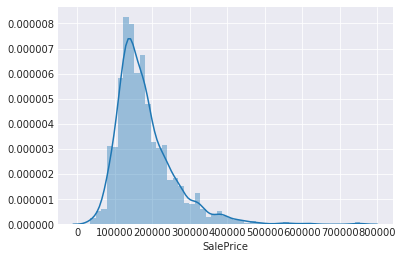

In [6]:
sns.distplot(train['SalePrice'] );
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

从图中看出价格的分布还是挺偏的，具体的偏度由偏态系数(skewness)和峰态系数(Kurtosis)量化指出.一般在数据分析的时候带入模型的数据符合正态分布的话效果会比较好，而越接近正态分布偏态系数(skewness)应该越接近0的。为了改善这个状况我把这个值取log使得它的分布接近正太分布，如下所示：

Skewness: 0.121335


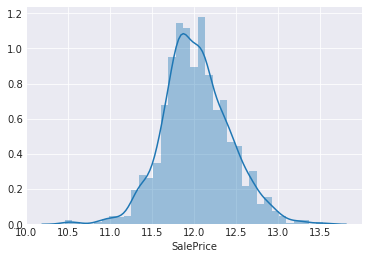

In [7]:
sns.distplot(np.log(train['SalePrice']) );
print("Skewness: %f" % np.log(train['SalePrice']).skew())

然后看看剩下的79个特征

In [8]:
print('全部特征包括：', len(test.select_dtypes(include=['object']).columns), '个类别特征',
      len(test.select_dtypes(include=['int64','float64']).columns), '个数字特征')
train.columns.to_series().groupby(train.dtypes).groups

全部特征包括： 43 个类别特征 37 个数字特征


{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

如上所示：本数据集有43个类别特征和37个数字特征，一般来说类别特征标识的是这个房子按照某标准划分下的所属类别，数字特征是描述这个房子某项参数上的值，但是这个数据集里面有些不合理的方面，比如MSSubClass这个特征，它在表中的值是数值型的，但是它表示的意义却不是数值型，它是对一个房子从新旧和风格还有有没有阁楼这些角度去分类的，它的值虽然是20,30,60,160这些数字，但是却没有数学上的意义比如数学上20+30=50，但是MSSubClass里面20指的是有1个储藏室1946年以后的房子，30则是有1个储藏室1946年之前的房子,50却是表示带阁楼的房子，这里20+30=50这种关系完全不存在还很荒谬。所以在后面的数据清理部分要把这种类型的数值型数据全部转换为字符串型的才合理。

下面，看看这些特征和预测目标'SalePrice'之间的关系。根据我自己以往的经验，房价跟房子的面积肯定是息息相关的，一般来说肯定房子越大越贵吧（GrLivArea），还有就是地段越好越贵哇（Neighborhood），其他条件一样的话新盖的盖的房子应该贵一些（YearBuilt），配套设施越好应该价格也会越高。下面我先画个关系矩阵热力图看看特征之间的关系，重点看一下SalePrice跟其它特征的关系。（因为我深刻的明白北京跟太原房价的差异所以我比较重视地段属性，而原数据中Neighborhood是字符型数据所以我这里先把他转换成数值型方便画热力图）

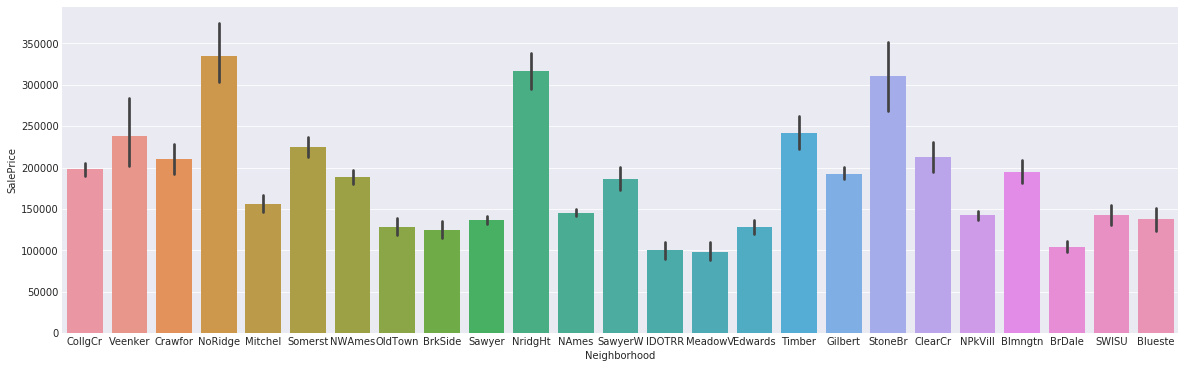

In [9]:
# 先画个柱状图看看
plt.figure(figsize=(20,6))
sns.barplot(x='Neighborhood', y = 'SalePrice', data=train)

根据上图把这几个区域进行一下评级工作。'MeadowV'这个区域房价最低，有可能环境设施比较差，估计犯罪率也比较高，所以评定为最低级1， 'IDOTRR'和'BrDale'稍好为2，'OldTown' 'Edwards' 'BrkSide'是3，以此类推把Neighborhood属性转换为1到10的数值型属性nNeighborhood。

In [10]:
train["nNeighborhood"] = train.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})

这里我只是为了画热力图才这样转化的，后面数据清洗的时候，这个属性还是类别型，不转换成数值型。nNeighborhood这一列也要删掉。还有就是我只关心特征和房价的关系所以我这里只选取了排名前十的特征画图。

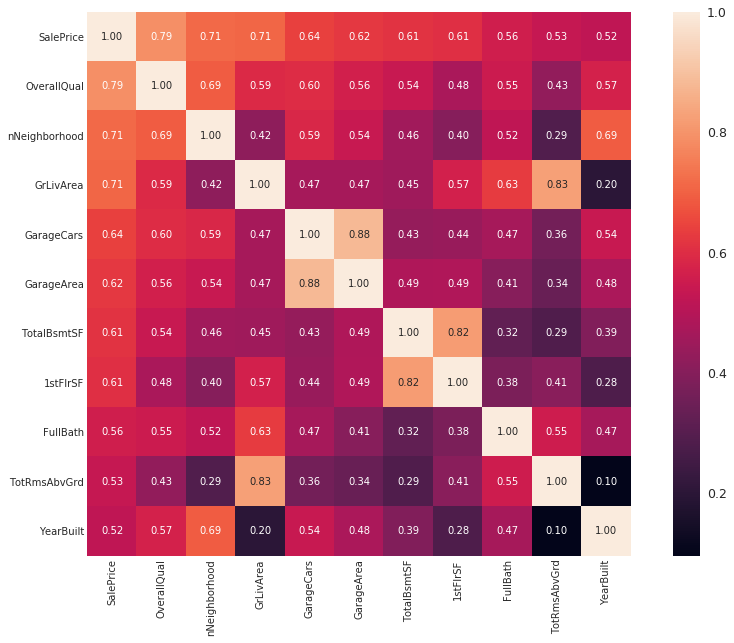

In [11]:
# 画关系矩阵热力图
f, ax = plt.subplots(figsize=(15, 10))
corrmat = train.corr()
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

如图所示，关系排行榜第一位的是OverallQual....emmmm，这是什么东西经过查找数据说明文档，发现这个特征是对房子的综合评级：一共有十个等级从Very Poor到Very Excellent用1到10来打分，难怪跟房价的关系排名第一位了。 紧随其后的如之前所料是GrLivArea和nNeighborhood这两个特征。GrLivArea是房子的居住面积，Neighborhood是房子所在的社区。接着的是车库大小，这个还挺意外的，毕竟天朝不是家家有车库，看来美国人民对车库的需求还是比较高的。比较让我意外的是建造时间特征只排第十名，说明房子新旧不是很重要，也许因为他们可以随意改造和重盖自己的房子吧....

## 数据清洗

根据上面的分析结果接下来我要对数据进行清洗工作，首先要把前面说过的要删除的列删掉，然后再根据关系排名重点处理靠前的特征数据里面的异常值。

In [12]:
# 把ID保存下来然后在数据集中去掉
train_ID = train['Id']
test_ID = test['Id']
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)
targets=train['SalePrice']
print(targets.shape)
train.shape

(1460,)


(1460, 81)

### 异常值处理

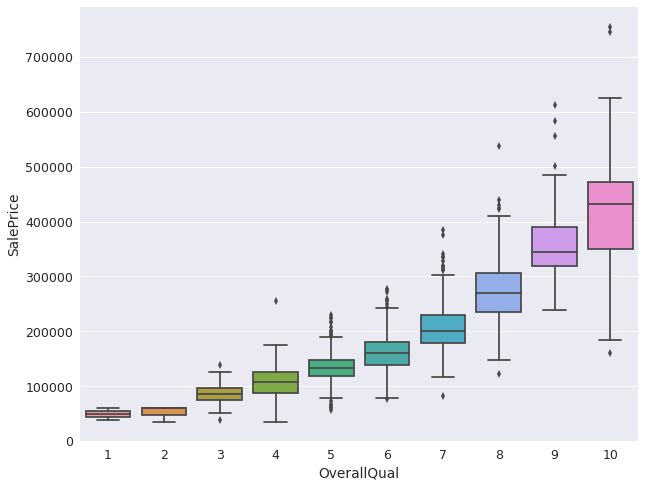

In [13]:
# 首先处理排名第一位的Overall Quality
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x= 'OverallQual', y="SalePrice", data=train)

没看出什么问题基本走向是正常的，评级越高房价也越高。

(1460, 81)

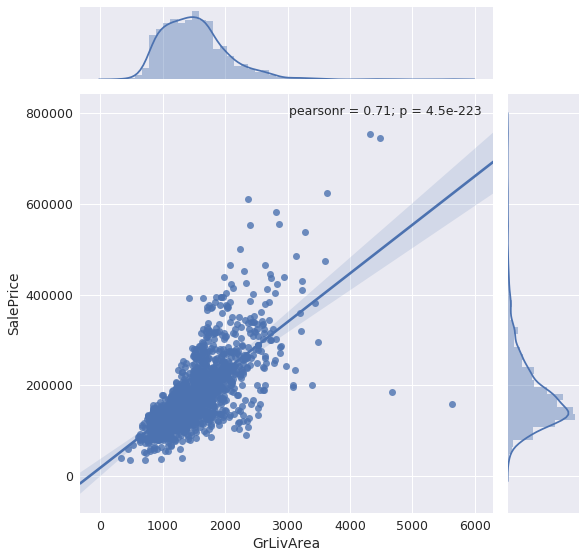

In [14]:
# 然后看排第二的Living Area
sns.jointplot(x="GrLivArea", y = "SalePrice", data=train, size = 8, kind="reg");
train.shape

房子生活区面积大部分分布在800到1800之间。价格集中在20000附近。生活区域的面积大小和房子的价格之间存在一个正相关的关系，但是右下角的两个离群点面积很大但是价格却很低，不是鬼屋就是出错了。会对模型造成干扰需要从数据中踢出去。

In [15]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<400000)].index,inplace=True)
train.shape

(1458, 81)

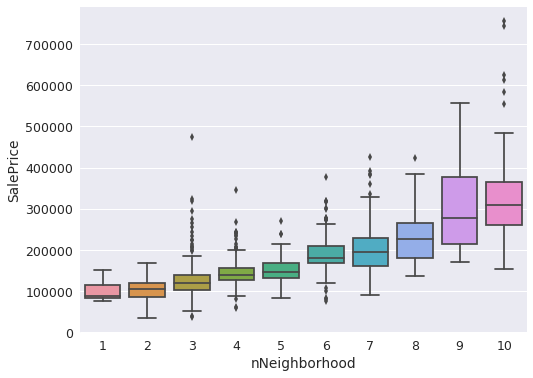

In [16]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=train['nNeighborhood'], y=train['SalePrice'])

如图所示评级在3级的社区里面出现一个房价接近50万的房子。就算他有游泳池和小栅栏，我也极度怀疑他是一个异常点。所以我要把它从数据中踢出去。还有最右上角那两个点也太突破天际了，不过我还是留下它吧，毕竟他是符合基本走向的。而且在上一张图我发现它俩的居住面积也是很大的。它俩的房主真的是土豪。

In [17]:
train.drop(train[(train["nNeighborhood"]==3)&(train["SalePrice"]>400000)].index,inplace=True)
train.shape

(1457, 81)

In [18]:
# 分析完以后把之前新加的nNeighborhood列删了
train.drop('nNeighborhood', axis = 1, inplace = True)

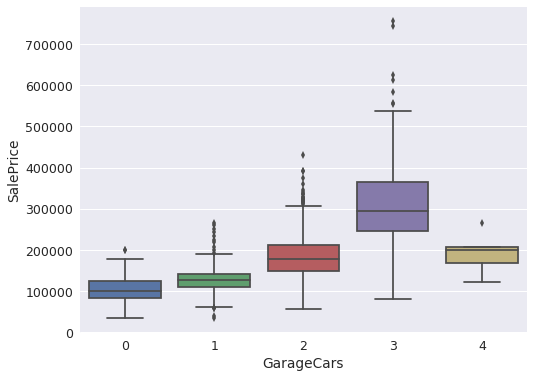

In [19]:
# 接下来是GarageCars
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])
# sns.jointplot(x="GarageCars", y = "SalePrice", data=train, size = 8, kind="reg");

有配备四个车位的车库的房子竟然价格如此之低才20万多，这真是奇怪，光四个车位也顶的上一个主卧的面积了。所以我判断他们是异常点应该删掉。

In [20]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)
train.shape

(1452, 80)

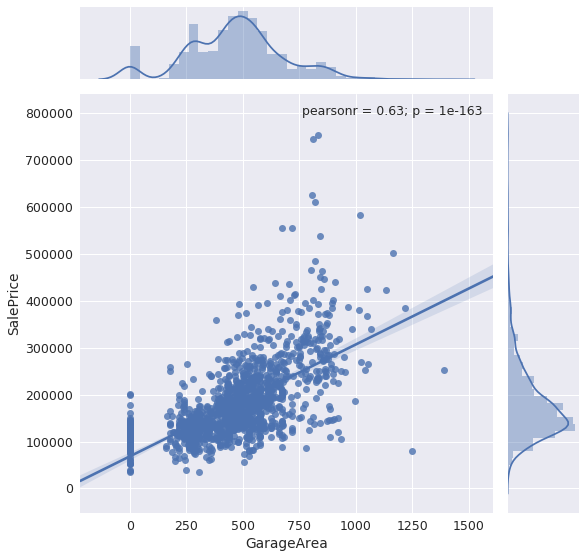

In [21]:
# 车库面积属性
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'],size = 8, kind='reg')

右下角有个点车库面积巨大但是房价很低，也删了吧

In [22]:
train = train.drop(train[(train['GarageArea']>1000) 
                         & (train['SalePrice']<200000)].index).reset_index(drop=True)
train.shape

(1451, 80)

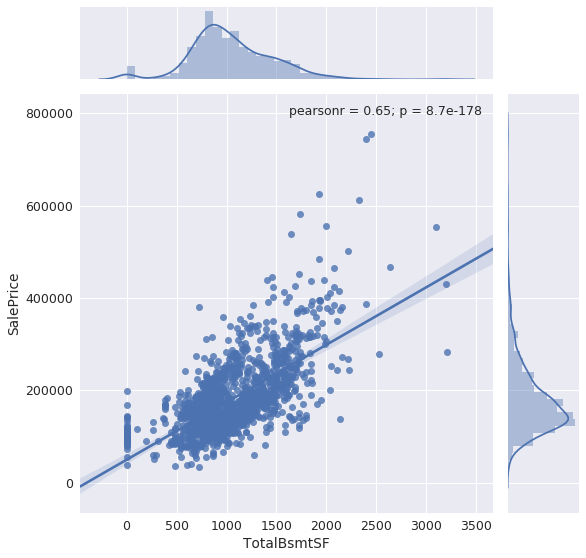

In [23]:
# 地下室总面积
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], size = 8, kind='reg')

这个嘛，没啥异常的，只是有些房子不带地下室而已

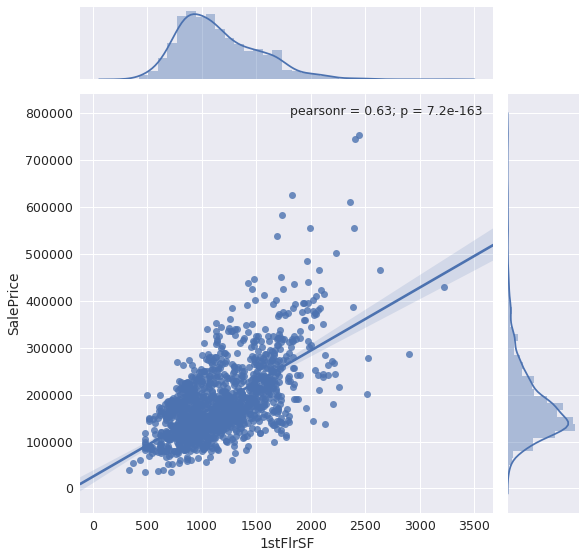

In [24]:
# 第一层的面积
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'],  size = 8, kind='reg')

这个也没啥问题，可恶的美帝，住的房子都好几层，太罪恶了。后面的特征相关性就不是那么高了，就不看了。

### 缺失值处理

处理完训练集中的异常值后，把SalePrice列删了，因为接下来要把train数据集和test数据集合并处理缺失值。

In [25]:
# 合并train和test集
full = train.append(test)
full.drop('SalePrice',axis=1, inplace=True)
full.shape

(2910, 79)

In [26]:
# 查看各属性下的缺失值
absentValues = full.isnull().sum()
# print(absentValues[absentValues>0].sort_values(ascending=False))
pd.DataFrame({'Missing Values' :absentValues[absentValues>0].sort_values(ascending=False)})

,Missing Values
PoolQC,2901
MiscFeature,2806
Alley,2713
Fence,2341
FireplaceQu,1416
LotFrontage,485
GarageQual,159
GarageCond,159
GarageFinish,159
GarageYrBlt,159


如上所示缺失值还挺多的，下面具体来分析一下上面的这些缺失的值代表了什么和怎么去补。  

"MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea" 这几个数值型的都补成0，因为他们没填就是因为没有，比如房子没有第二层，没有地下室，没有车库自然也就没有这些值了。

"PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"这几个字符型值补成None，因为他们的缺失值表示的是"没有"。房子根本不带地下室，壁炉，没有栅栏，根本没见过游泳池等等。  

"MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"这几个属性的缺失值补它们的众数。

最后来看看LotFrontage，文档里它的描述是Linear feet of street connected to property。指的是房子前面的到马路之间的一块空地的长度。经过搜索...发现缺失的值有两种补全方式，第一种是用房子所在区域(Neighborhood)分组，然后用它们这个区域房子的LotFrontage的平均值补全.第二种方式是根据LotArea这个属性去分组然后用组内的LotFrontage的平均值补全，外国的房子我真不懂不过感觉LotArea是宅基地面积的意思，这个LotFrontage是算在宅基地面积里的应该是，所以我觉得根据LotArea这个属性补全应该比较有道理。

下面先来补LotFrontage，LotArea这个属性是连续值所以要先把他进行分桶离散化。分10个吧，大家都分10个：

In [27]:
# 分桶离散化
full['LotAreaCut'] = pd.qcut(full.LotArea,10)
# 然后就可以groupby去补上缺失值了
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
# 最后把新添加的LotAreaCut列删了
full.drop('LotAreaCut',axis=1,inplace = True)

# 再把别的列的缺失值按照前面说的原则补上
cols1=['MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageArea']
for col in cols1:
    full[col].fillna(0, inplace=True)
    
cols2 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols2:
    full[col].fillna("None", inplace=True)    

cols3 = ['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'Functional', 'Electrical', 'KitchenQual', 'SaleType','Exterior1st', 'Exterior2nd']
for col in cols3:
    full[col].fillna(full[col].mode()[0], inplace=True) #mode()函数返回的不一定是一个值所以取第一个[0]

经过上面的处理数据集干净了不少，下面可以进行下一步了。

## 特征工程

#### 转换部分特征的数据类型

通过之前的观察可知数据集的80个特征中有一部分特征的值是数字，但是其实它代表的意义其实是不同的类别，比如前面提到的MSSubClass。接下来我先把这样的数字特征的值转化为字符类型。

In [28]:
cols = ['MSSubClass','BsmtFullBath','BsmtHalfBath','HalfBath','BedroomAbvGr','KitchenAbvGr']
for col in cols:
    full[col]=full[col].astype(str)

#### 添加一些比较合理的特征组合为新特征

数据集的特征中有些特征之间关联性很强，可以组合成新特征。比如1层面积加上2层面积加上地下室面积就是总面积等，据此构造出以下新特征：

In [29]:
full["TotalHouse"] = full["TotalBsmtSF"] + full["1stFlrSF"] + full["2ndFlrSF"]   
full["TotalArea"] = full["TotalBsmtSF"] + full["1stFlrSF"] + full["2ndFlrSF"] + full["GarageArea"]

full["TotalHouse_OverallQual"] = full["TotalHouse"] * full["OverallQual"]
full["GrLivArea_OverallQual"] = full["GrLivArea"] *full["OverallQual"]

full["BsmtFinSF1_OverallQual"] = full["BsmtFinSF1"] * full["OverallQual"]
full["LotArea_OverallQual"] = full["LotArea"] * full["OverallQual"]
full["TotalHouse_LotArea"] = full["TotalHouse"] + full["LotArea"]

full["Bsmt"] = full["BsmtFinSF1"] + full["BsmtFinSF2"] + full["BsmtUnfSF"]
full["Rooms"] = full["FullBath"]+full["TotRmsAbvGrd"]
full["PorchArea"] = full["OpenPorchSF"]+full["EnclosedPorch"]+full["3SsnPorch"]+full["ScreenPorch"]
full["TotalPlace"] = full["TotalBsmtSF"] + full["1stFlrSF"] + full["2ndFlrSF"] + full["GarageArea"] + full["OpenPorchSF"]+full["EnclosedPorch"]+full["3SsnPorch"]+full["ScreenPorch"]


#### 处理偏差较大的特征


如之前分析的SalePrice那样这些特征里的值的分布情况也是千差万别，有的比较标准，有的可能偏差很大，把偏离值很大的数据喂给模型的话，模型训练这样的数据发挥不出好的效果。所以接下来我要对每个特征中的数据都进行一些处理，比如归一化，标准化等。下面就把这些特种中偏差值大于0.5的列进行一下标准化处理。一般标准化处理的方式是取对数，但是统计学里还有一种叫Box Cox transform的方法，不过我不是学统计的，不是很明白这个变换是怎么弄的，以后可以进一步了解一下。

In [30]:
# 对数据集中的所有整型和浮点型的列分别计算偏离度把其中偏离值大于0.5的进行处理
X_numeric=full.select_dtypes(exclude=["object"])
skewness = X_numeric.apply(lambda x: skew(x))
skewness_features = skewness[abs(skewness) >= 0.5].index
print(skewness_features)
full[skewness_features] = np.log1p(full[skewness_features])

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'GrLivArea', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF',
       'OverallCond', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'WoodDeckSF', 'YearBuilt', 'TotalHouse', 'TotalArea',
       'TotalHouse_OverallQual', 'GrLivArea_OverallQual',
       'BsmtFinSF1_OverallQual', 'LotArea_OverallQual', 'TotalHouse_LotArea',
       'Bsmt', 'Rooms', 'PorchArea', 'TotalPlace'],
      dtype='object')


然后下一步是把特征里类别类型的离散特征特征进行独热编码，它可以把这些离散的特征映射到欧式空间，使特征间距离计算更合理。

In [31]:
full=pd.get_dummies(full)
full.shape

(2910, 447)

#### 特征数据标准化处理

下面把所有特征下面的数据标准化，以保障在非树结构模型下的训练效果。

In [32]:
# 用鲁棒标准化也许健壮性能强一些把
scaler = RobustScaler()
n_train=train.shape[0]

X = full[:n_train]
test_X = full[n_train:]

y= train.SalePrice

trainScaled = scaler.fit(X).transform(X) #幅度缩放
y=train.SalePrice
y_log = np.log(train.SalePrice) #把有偏峰的值处理成比较符合正态分布的值
testScaled = scaler.transform(test_X)
trainScaled.shape

(1451, 447)

之前加入了太多的特征维度，这些特征维度之间关联性也强，做个PCA还是维持同样的维度，我觉得就相当于重新选了一套坐标系去描述这整个特征空间，只是这套新坐标系下原来那些点更分散了，更清晰一些。

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=447)
trainScaled=pca.fit_transform(trainScaled)
testScaled = pca.transform(testScaled)

trainScaled.shape, testScaled.shape, 

((1451, 447), (1459, 447))

## 建模与预测

In [34]:
# 先声明一下，以我目前的水平来看，建模与预测部分是玄学，非贬义。

建模预测阶段的流程大概是这样的：首先，这是个回归问题，所以先拿出一些回归模型在上面跑跑看。然后从中选出几个有前途的，进行详细的调参，把它们调到最好状态来提高预测准确性。再然后用模型融合的手段把它们融合在一起，来进一步提高预测的准确性。最后用最终模型集合预测结果，写入文件上交。

先定义一个函数，用交叉验证的方法训练并给各个模型打分。评价标准是mean_squared_error均方误差然后我自己给他开个方，就成了rmse了。

In [35]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

然后找几个模型来跑跑看

In [39]:
lasso = Lasso(alpha=0.01,max_iter=10000)
ridge = Ridge()
svr = SVR()
ker = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
ela = ElasticNet(alpha=0.001,max_iter=10000)
bay = BayesianRidge()
rf = RandomForestRegressor()
model_xgb = xgb.XGBRegressor()

models=[lasso,ridge,svr,ker,ela,bay,rf,model_xgb]
names=['lasso','ridge','svr','ker','ela','bay','rf','model_xgb']
for name, model in zip(names,models):
    score = rmse_cv(model, trainScaled, y_log)
 
    print("{} score: {:.4f} ({:.4f})\n".format(name,score.mean(), score.std()))

lasso score: 0.1330 (0.0068)

ridge score: 0.1214 (0.0082)

svr score: 0.1171 (0.0089)

ker score: 0.1124 (0.0072)

ela score: 0.1136 (0.0076)

bay score: 0.1131 (0.0078)

rf score: 0.1536 (0.0134)

model_xgb score: 0.1397 (0.0070)



大致看来发现树结构的模型好像不太适合用来分析这个数据集，尤其是随机森林。所以我决定放弃树模型，下面是对其余几个模型调参，争取把各个模型调整到最好状态。我用的是grid暴力调参。

In [40]:
lasso = Lasso()
param= {'alpha': [0.0005,0.0002,0.0003,0.0004],'max_iter':[10000]}
grid_search = GridSearchCV(lasso,param_grid=param,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(trainScaled,y_log)
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

{'max_iter': 10000, 'alpha': 0.0004} 0.11345819405777781
                                 params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 0.0005}         0.113806        0.001745
1  {'max_iter': 10000, 'alpha': 0.0002}         0.114967        0.001803
2  {'max_iter': 10000, 'alpha': 0.0003}         0.113534        0.001778
3  {'max_iter': 10000, 'alpha': 0.0004}         0.113458        0.001760


In [41]:
ri = Ridge()
param = {'alpha':[15,20,25,30,35]}
grid_search = GridSearchCV(ri,param_grid=param,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(trainScaled,y_log)
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

{'alpha': 25} 0.11299462309001462
          params  mean_test_score  std_test_score
0  {'alpha': 15}         0.113186        0.001746
1  {'alpha': 20}         0.113013        0.001739
2  {'alpha': 25}         0.112995        0.001737
3  {'alpha': 30}         0.113056        0.001738
4  {'alpha': 35}         0.113163        0.001741


In [42]:
kr = KernelRidge()
param={'alpha':[0.1,0.2,0.3], 'kernel':["polynomial"], 'degree':[3],'coef0':[1.2,0.8]}
grid_search = GridSearchCV(kr,param_grid=param,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(trainScaled,y_log)
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

{'coef0': 1.2, 'alpha': 0.2, 'degree': 3, 'kernel': 'polynomial'} 0.11117272342463602
                                              params  mean_test_score  \
0  {'coef0': 1.2, 'alpha': 0.1, 'degree': 3, 'ker...         0.111876   
1  {'coef0': 0.8, 'alpha': 0.1, 'degree': 3, 'ker...         0.111196   
2  {'coef0': 1.2, 'alpha': 0.2, 'degree': 3, 'ker...         0.111173   
3  {'coef0': 0.8, 'alpha': 0.2, 'degree': 3, 'ker...         0.111628   
4  {'coef0': 1.2, 'alpha': 0.3, 'degree': 3, 'ker...         0.111241   
5  {'coef0': 0.8, 'alpha': 0.3, 'degree': 3, 'ker...         0.112455   

   std_test_score  
0        0.001439  
1        0.001401  
2        0.001440  
3        0.001434  
4        0.001462  
5        0.001461  


In [43]:
svr = SVR()
param = {'C':[15,16],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.006,0.008]}
grid_search = GridSearchCV(svr,param_grid=param,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(trainScaled,y_log)
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

{'gamma': 0.0004, 'kernel': 'rbf', 'epsilon': 0.008, 'C': 15} 0.11086578915647269
                                              params  mean_test_score  \
0  {'gamma': 0.0003, 'kernel': 'rbf', 'epsilon': ...         0.110919   
1  {'gamma': 0.0004, 'kernel': 'rbf', 'epsilon': ...         0.110936   
2  {'gamma': 0.0003, 'kernel': 'rbf', 'epsilon': ...         0.110941   
3  {'gamma': 0.0004, 'kernel': 'rbf', 'epsilon': ...         0.110866   
4  {'gamma': 0.0003, 'kernel': 'rbf', 'epsilon': ...         0.110958   
5  {'gamma': 0.0004, 'kernel': 'rbf', 'epsilon': ...         0.110949   
6  {'gamma': 0.0003, 'kernel': 'rbf', 'epsilon': ...         0.110915   
7  {'gamma': 0.0004, 'kernel': 'rbf', 'epsilon': ...         0.110873   

   std_test_score  
0        0.001898  
1        0.001922  
2        0.001905  
3        0.001933  
4        0.001901  
5        0.001913  
6        0.001912  
7        0.001926  


In [44]:
en = ElasticNet()
param={'alpha':[0.006,0.004,0.005],'l1_ratio':[0.08,0.1,0.06],'max_iter':[10000]}
grid_search = GridSearchCV(en,param_grid=param,cv=5, scoring="neg_mean_squared_error")
grid_search.fit(trainScaled,y_log)
print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

{'l1_ratio': 0.06, 'max_iter': 10000, 'alpha': 0.005} 0.11316421942187858
                                              params  mean_test_score  \
0  {'l1_ratio': 0.08, 'max_iter': 10000, 'alpha':...         0.113861   
1  {'l1_ratio': 0.1, 'max_iter': 10000, 'alpha': ...         0.114612   
2  {'l1_ratio': 0.06, 'max_iter': 10000, 'alpha':...         0.113342   
3  {'l1_ratio': 0.08, 'max_iter': 10000, 'alpha':...         0.113224   
4  {'l1_ratio': 0.1, 'max_iter': 10000, 'alpha': ...         0.113440   
5  {'l1_ratio': 0.06, 'max_iter': 10000, 'alpha':...         0.113217   
6  {'l1_ratio': 0.08, 'max_iter': 10000, 'alpha':...         0.113458   
7  {'l1_ratio': 0.1, 'max_iter': 10000, 'alpha': ...         0.113941   
8  {'l1_ratio': 0.06, 'max_iter': 10000, 'alpha':...         0.113164   

   std_test_score  
0        0.001724  
1        0.001737  
2        0.001736  
3        0.001746  
4        0.001733  
5        0.001754  
6        0.001730  
7        0.001727  
8        0.0017

OK，磨炼人类意志与耐心的调参环节过去了，下面进入更摧残人的环节，模型融合。其实模型融合比调参要轻松不少，前提是如果我会stacking的话。我在此之前通过搜索手段发现stacking这种融合方式比较容易获得好的效果所以我决定融合手段就选stacking了。然后我发现了，sklearn没提供直接可以用的stacking包，此后我通过搜索，发现了一个stacking的介绍图，结果还是错的，不过磕磕绊绊总算是很简陋的把stacking过程完成了哇，还是很开心的。唉，太弱了。

stacking的基本流程是这样的：stacking是分层结构的，我这里用了两层，因为我用了三层以后结果反而不如两层的。首先把前面调好参的m个模型作为第一层的base models，然后分别用这几个最佳状态的base models用类似n折交叉验证的方式把训练集分成验证集和训练集去拟合，拟合n次，其中每一次都要对从训练集里分出来的验证集和本来的测试集进行预测，而且要把每次的预测结果都保存下来。训练完一个模型以后此时要把保存的n份对测试集的预测结果取平均值，保存起来。然后再训练下一个模型，过程跟第一个模型一样。直到把所有base models训练完，这时候手上会有m个对训练集的预测结果，和m个对测试集的预测结果。然后用这两个结果再去训练第二层的model，最后再用第二层这个model再去预测测试集数据得到最终结果。OK，不知道你看晕没，反正我写的挺痛快。下面开始：

下面的stacking过程及其简陋，以至于我自己都不忍直视。。。请酌情慎看

#### 这是第一层

In [45]:
# 下面这个n就是前文中提到的n也就是单个基模型训练的次数
n_splits=5     #相当于每个模型做个5折交叉验证
kf = KFold(n_splits=5, random_state=42, shuffle=True) #宇宙密码42  split函数可以把数据集分成n份返回的是index

# 用split函数y_log会莫名出现缺失值，导致程序无法运行，所以这里用Imputer()处理一下数据集，这个错误我debug了一下午，最后虽然通过搜索找到了这个方法
# 然而我却不知道问题形成的原因待日后问问老师吧。
trainScaled = Imputer().fit_transform(trainScaled)
y_log = Imputer().fit_transform(y_log.reshape(-1,1)).ravel()

def stacker(clf):
    A = np.zeros((len(trainScaled),))   #这个用来存储5次循环交叉验证完以后的对训练集整体的预测结果，它的行数跟训练集相同
    B = np.zeros((len(testScaled),))    #这个用来存储5次对测试集验证结果的平均值的,它的行数跟测试集相同
    c = np.empty((n_splits, len(testScaled)))  #因为是5折交叉训练所以这里对测试集预测了5次，最后要取平均方到B里
    i=0
    for train_index, validation_index in kf.split(trainScaled,y_log):

        trainset = trainScaled[train_index]     #因为是5折交叉验证，所以训练集是5分之4，验证集是5分之1
        trainLabelset = y_log[train_index]      #这是标签
        validationset = trainScaled[validation_index]    #这是从原训练集里取出来的5分之一验证集

        clf.fit(trainset,trainLabelset)
        #下面这里存着的是验证集的预测结果验证集其实就是5分之1的训练集，循环5次以后就是针对全部训练集的预测结果
        A[validation_index] = clf.predict(validationset)
        
        c[i,:] = clf.predict(testScaled) #这里存的是对测试集的预测结果
        i=i+1

    B[:] = c.mean(axis=0) 

    return A.reshape(-1,1), B.reshape(-1,1) 
 
# 根据上一步调好的参数创建下面这些base models
lasso = Lasso(alpha=0.0004,max_iter=10000)
ridge = Ridge(alpha=25)
svr = SVR(gamma= 0.0004,kernel='rbf',C=15,epsilon=0.008)    
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=1.2)
ela = ElasticNet(alpha=0.005,l1_ratio=0.06,max_iter=10000)
bay = BayesianRidge()

# 分别对每个函数进行一次5折交叉训练，把对训练集和测试集的预测结果取出来存到两个变量中
lass_stack_train, lass_stack_test = stacker(lasso)
ridge_stack_train, ridge_stack_test = stacker(ridge)
svr_stack_train, svr_stack_test = stacker(svr)
ker_stack_train, ker_stack_test = stacker(ker)
ela_stack_train, ela_stack_test = stacker(ela)
bay_stack_train, bay_stack_test = stacker(bay)

# 把上面的对训练集和测试集的预测结果拼接起来分别作为下一层模型的训练集和测试集。
x_train = np.concatenate((lass_stack_train, ridge_stack_train, svr_stack_train,ker_stack_train,ela_stack_train,bay_stack_train), axis=1)
x_test = np.concatenate((lass_stack_test, ridge_stack_test, svr_stack_test, ker_stack_test,ela_stack_test,bay_stack_test), axis=1)


#### 这是第二层

下面是stacking的第二层，我第二层只用了一个模型，其实这一层也可以用多个模型把上面产生出来的训练集和测试集像第一层那样去弄，然后再把得出的训练集和测试集扔到第三层去。我完了会把stacker这个函数再封装一下，外面再加个循环，这样一层不管有几个base model只用调一次就行了。像上面那样有几个模型调用几次真的很蠢。

In [46]:
k = KernelRidge(alpha=0.2, coef0=0.35, degree=3, gamma=None, kernel='polynomial',kernel_params=None)
k.fit(x_train,y_log)
pred = np.exp(k.predict(x_test))
# 把预测结果保存到文件中提交
result=pd.DataFrame({'Id':test_ID, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)

## 总结

这是最后一次考试了，感觉也是最忙的一次考试。把最后的结果提交得到的分数是0.11321。本来开篇的时候还想写个正经向的技术类report的，结果现在写成了博客日记和心情分享了，主要还是自己水平太低，做这个实验期间各种摸不着头脑找不到北，不过从数据分析，处理到特征工程建模这一趟走下来，还是很有收获的，积累了很多处理数据的小技巧。比如不同数据类型的特征应该如何处理之类的。最大的收获就是知道自己菜在哪了。以后学习的时候更有目标了。因为学的不扎实，我在前面的阶段花了太多的时间，后面建模的时候对模型的理解不够深刻，不知道该怎么选择模型，试了几个知道的模型发现效果都不太好,然后注意力被stacking转走很多，花了很多时间去研究stacking。然后又是通过搜索才发现上面这些模型的效果不错，然而好几个我之前都不认识！那么多种模型的特性，实现方式我都还没掌握。真的很惭愧。真心觉得课程太短了，以后应该开个kaggle竞赛班，一周一个竞赛，贼嗨。